# Group Analysis - FOOOFed EEG Analysis: Task
    
Applying FOOOF to task based EEG data, and comparing between YNG and OLD groups.

Notes:
- average power spectra vs. average FOOOFs
    - there are 10 segments that don't return a value in the single channel version
        - segments, with all-channel or canonical, have systematically different (lower) alpha power

From the 'ALL' group: 
- best performance (for both canonical & FOOOF) is from dropping those segments
- when doing single channel FOOOF, there is a benefit of other alpha features (CF & BW) 

Status:
- FOOOF fits can help select data to analyze
- Gives more features to use to predict behaviour, and can outperform canonical when these features are combined

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import warnings
from copy import deepcopy
from os.path import join as pjoin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, ttest_1samp, normaltest

import patsy
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import compare_cox, compare_j

from fooof.sim.gen import gen_aperiodic, gen_power_spectrum
from fooof.plts import plot_spectra

In [3]:
# Import custom code for this analysis
import sys
sys.path.append('../code')

from plts import *
from utils import *
from data_mgmt import *
from analysis import *

# Settings

In [4]:
# Import general settings
from settings import YNG_INDS, OLD_INDS
from settings import RESULTS_PATH

In [5]:
# Set which group of FOOOF results to load
#folder = 'FOOOF-SinCh'        # FOOOF fit on an average across power spectra 
#folder = 'FOOOF-AllCh'         # Average across FOOOF fits, from each channel
folder = 'FOOOF'

# Model settings - which group to run
group = 'ALL' # 'ALL', 'YNG', 'OLD'

print('Number of YNG subjects: ', len(YNG_INDS))
print('Number of OLD subjects: ', len(OLD_INDS))

Number of YNG subjects:  17
Number of OLD subjects:  14


In [6]:
# Data settings
srate = 512
tmin, tmax = -0.85, 1.1
times = np.arange(tmin, tmax, 1/srate)
seg_times = [(-0.85, -0.35), (0.1, 0.6), (0.5, 1.0)]
n_subjs = 31
dict_structure = {'YNG' : {}, 'OLD' : {}, 'ALL' : {}}

# Set the time segments indices to compute the difference measures with
i1, i2 = 2, 0

In [7]:
# Wether to save out plots or not
SAVE_FIG = False

### Check dropped trials

In [8]:
# Load dropped trials & components
dropped_trials = np.load(pjoin(RESULTS_PATH, 'Group', 'dropped_trials.npy'))
dropped_components = np.load(pjoin(RESULTS_PATH, 'Group', 'dropped_components.npy'))

# Check dropped trials for each subject
print('SubNum \t\t # Dropped Trials \t # Dropped Components')
for ind, trials, components in zip(range(n_subjs), dropped_trials, dropped_components):
    temp_trials = trials[trials < 999.]
    temp_comps = components[components < 999.]
#    print(ind, '\t\t', len(temp_trials), '\t\t\t', len(temp_comps))

SubNum 		 # Dropped Trials 	 # Dropped Components


## Group FOOOFing - Trial Averaged Data

Notes:
- 3D data objects have the shape `[n_loads, n_subjs, n_times]`

### Load Data

In [9]:
# Load behavioural data
behav_dat = pd.read_csv(pjoin(RESULTS_PATH, 'Behav', 'neural_aging_data_behaviour.csv'))

In [10]:
# Convert data types
behav_dat['Age'] = behav_dat['Age'].astype('str')
behav_dat['Load'] = behav_dat['Load'].astype('str')

In [11]:
# Calculate average behaviour across loads
avg_behav = behav_dat.groupby('SubjID').mean()

In [12]:
# Load and extract FOOOF data
load_side = 'Contra'
all_offsets, all_exps = load_fooof_task_ap(RESULTS_PATH, load_side, folder)
all_alphas_cf = load_fooof_task_pe(RESULTS_PATH, load_side, 0, folder)
all_alphas_pw = load_fooof_task_pe(RESULTS_PATH, load_side, 1, folder)
all_alphas_bw = load_fooof_task_pe(RESULTS_PATH, load_side, 2, folder)
all_r2s, all_errs = load_fooof_task_md(RESULTS_PATH, load_side, folder)

In [13]:
# Load canonical alpha analysis
canalph_group = np.load(pjoin(RESULTS_PATH, 'Group', 'canonical_group.npy'))

# Load individualized frequency canonical alpha analysis
canalph_icf_group = np.load(pjoin(RESULTS_PATH, 'Group', 'canonical_icf_group.npy'))

In [14]:
# Average across analytic alpha measures to get canonical alpha measure
seg_masks = []
for seg in seg_times:
    seg_masks.append(np.logical_and(times >= seg[0], times <= seg[1]))

canalpha = np.zeros_like(all_alphas_pw)
canal_icf = np.zeros_like(all_alphas_pw)
for subi, (canalph_dat, canalph_icf_dat) in enumerate(zip(canalph_group, canalph_icf_group)):
    for lodi in range(3):
        for segi, mask in enumerate(seg_masks):
            canalpha[lodi, subi, segi] = np.mean(canalph_dat[lodi, mask])
            canal_icf[lodi, subi, segi] = np.mean(canalph_icf_dat[lodi, mask])

#### Data Checks

In [15]:
# Check number of missing FOOOFed alphas
print('Number of missing FOOOFed alphas: \t', np.sum(np.isnan(all_alphas_pw)))

Number of missing FOOOFed alphas: 	 0


In [16]:
# Check if there are any NaN values
nans = np.isnan(all_alphas_pw)
print('Total number of NaN values:\t\t', np.sum(nans))

Total number of NaN values:		 0


## Data Management

In [17]:
# Make a data dictionary - each with shape [n_conds, n_times]
data_dict = deepcopy(dict_structure)
diff_data_dict = deepcopy(dict_structure)
behav_dict = deepcopy(dict_structure)

In [18]:
# Collect the data and labels into lists for checking through
labels = ['offset', 'exponent', 'alpha_cf', 'alpha_pw', 'alpha_bw', 'canalpha', 'canal_icf']
datas = [all_offsets, all_exps, all_alphas_cf, all_alphas_pw, all_alphas_bw, canalpha, canal_icf]

In [19]:
# Set up data & diff_data dicts
for label, data in zip(labels, datas):
    data_dict['YNG'][label], data_dict['OLD'][label] = reshape_dat(data)
    data_dict['ALL'][label] = np.concatenate([data_dict['YNG'][label],
                                              data_dict['OLD'][label]])
    
    diff_data_dict['YNG'][label] = calc_diff(data_dict['YNG'][label], i1, i2)
    diff_data_dict['OLD'][label] = calc_diff(data_dict['OLD'][label], i1, i2)
    diff_data_dict['ALL'][label] = np.concatenate([diff_data_dict['YNG'][label],
                                                   diff_data_dict['OLD'][label]])

In [20]:
# Set up the behavioural data dict
for label in ["d'", "Load", 'CDA']:
    behav_dict['ALL'][label] = behav_dat[label].values
    behav_dict['YNG'][label] = behav_dat[behav_dat['Age'] == '1'][label].values
    behav_dict['OLD'][label] = behav_dat[behav_dat['Age'] == '2'][label].values

## Data Checking

Check the FOOOF fit measures, checking whether there is a systematic difference between the groups that could explain the differences. 

In [21]:
# Check if the fit metrics vary by group
for label, data in zip(['Error', 'R^2'], [all_errs, all_r2s]):
    print(label)
    m1, m2 = np.nanmean(data[:, YNG_INDS, :]), np.nanmean(data[:, OLD_INDS, :])
    print('\tMeans: \t\t  {:1.4f} \t {:1.4f} \t diff: {:1.4f}'.format(m1, m2, np.abs(m1-m2)))
    print_stat('\tt-test', *ttest_ind(data[:, YNG_INDS, :].flatten(),
                                      data[:, OLD_INDS, :].flatten()))

Error
	Means: 		  0.0360 	 0.0316 	 diff: 0.0043
	t-test: 	  3.0959 	 0.0022
R^2
	Means: 		  0.9733 	 0.9599 	 diff: 0.0134
	t-test: 	  4.5782 	 0.0000


In [22]:
# Check the correlation between FOOOF fit error & R^2
print_stat('Err-R^2 Corr', *spearmanr(all_errs.flatten(), all_r2s.flatten()))

Err-R^2 Corr: 	 -0.3316 	 0.0000


In [23]:
# Check if the fit metrics correlate with measured FOOOF parameters
print('\t\t  Error \t   R^2')
for label, data in zip(labels, datas):
    print_stat(label,
               spearmanr(all_errs.flatten(), data.flatten())[0],
               spearmanr(all_r2s.flatten(), data.flatten())[0])

		  Error 	   R^2
offset: 	  0.0828 	 0.6035
exponent: 	 -0.1176 	 0.6869
alpha_cf: 	  0.1621 	-0.0953
alpha_pw: 	  0.7591 	 0.1712
alpha_bw: 	  0.2681 	 0.2580
canalpha: 	  0.2465 	-0.0506
canal_icf: 	  0.2475 	-0.0955


## Descriptive Data Checks

In [24]:
# Print out mean values, per group
print('Average Values per measure, per group: \n')
print('\t\t   YNG \t\t  OLD')
for label in labels:
    print_stat(label,
               np.nanmean(diff_data_dict['YNG'][label]),
               np.nanmean(diff_data_dict['OLD'][label]))

Average Values per measure, per group: 

		   YNG 		  OLD
offset: 	 -0.0571 	-0.0508
exponent: 	 -0.0346 	-0.0074
alpha_cf: 	  0.0288 	 0.3000
alpha_pw: 	  0.0992 	-0.0022
alpha_bw: 	 -0.0814 	 0.0818
canalpha: 	  0.0000 	-0.0000
canal_icf: 	  0.0000 	-0.0000


In [25]:
# Print out standard deviations, per group
print('Standard deviation per measure, per group: \n')
print('\t\t   YNG \t\t  OLD')
for label in labels:
    print_stat(label,
               np.nanstd(diff_data_dict['YNG'][label]),
               np.nanstd(diff_data_dict['OLD'][label]))

Standard deviation per measure, per group: 

		   YNG 		  OLD
offset: 	  0.1060 	 0.1129
exponent: 	  0.0972 	 0.1240
alpha_cf: 	  0.4646 	 0.8481
alpha_pw: 	  0.1310 	 0.1132
alpha_bw: 	  0.3475 	 0.6170
canalpha: 	  0.0000 	 0.0000
canal_icf: 	  0.0000 	 0.0000


In [26]:
# Check for normality, per measure, per group
print('Normal test per measure, per group: \n')
print('YNG\t\t   stat \t  p-val')
for label in labels:
    print_stat(label, *normaltest(diff_data_dict['YNG'][label]))
print('\nOLD\t\t   stat \t  p-val')
for label in labels:
    print_stat(label, *normaltest(diff_data_dict['OLD'][label]))

Normal test per measure, per group: 

YNG		   stat 	  p-val
offset: 	  2.0162 	 0.3649
exponent: 	  0.6064 	 0.7384
alpha_cf: 	  0.7763 	 0.6783
alpha_pw: 	  30.5849 	 0.0000
alpha_bw: 	  1.2986 	 0.5224
canalpha: 	  30.7984 	 0.0000
canal_icf: 	  30.5457 	 0.0000

OLD		   stat 	  p-val
offset: 	  3.1296 	 0.2091
exponent: 	  3.1600 	 0.2060
alpha_cf: 	  7.5928 	 0.0225
alpha_pw: 	  2.2324 	 0.3275
alpha_bw: 	  14.4422 	 0.0007
canalpha: 	  5.7566 	 0.0562
canal_icf: 	  12.4550 	 0.0020


In [27]:
# Print out tests for group differences
print('T-Tests for Differences Between Groups (YNG vs OLD), per Metric: \n')
print('\t\t   t-val \t  p-val')
for label in labels:
    print_stat(label, *nan_ttest(diff_data_dict['YNG'][label],
                                 diff_data_dict['OLD'][label]))

T-Tests for Differences Between Groups (YNG vs OLD), per Metric: 

		   t-val 	  p-val
offset: 	 -0.2738 	 0.7849
exponent: 	 -1.1769 	 0.2423
alpha_cf: 	 -1.9342 	 0.0562
alpha_pw: 	  3.9043 	 0.0002
alpha_bw: 	 -1.5882 	 0.1157
canalpha: 	  2.8359 	 0.0056
canal_icf: 	  3.0555 	 0.0029


In [28]:
# Check correlations of physiology to behaviour, per group
print('Correlation (r-vals) of each metric with behaviour, per Group: \n')
print('\t\t   YNG \t\t  OLD')
for label in labels:
    print_stat(label,
    nan_corr(diff_data_dict['YNG'][label], behav_dict['YNG']["d'"])[0],
    nan_corr(diff_data_dict['OLD'][label], behav_dict['OLD']["d'"])[0])

Correlation (r-vals) of each metric with behaviour, per Group: 

		   YNG 		  OLD
offset: 	  0.1435 	 0.0341
exponent: 	  0.2729 	-0.1506
alpha_cf: 	  0.0938 	-0.1061
alpha_pw: 	 -0.1167 	 0.3955
alpha_bw: 	 -0.1312 	 0.1600
canalpha: 	 -0.2216 	 0.2717
canal_icf: 	 -0.2401 	 0.3341


## Fit Models to Predict Behaviour

Predict behaviour output from evoked responses of alpha and aperiodic. 

In [29]:
# Set up model definitions
models_defs = {
    'base_model' : 'behav ~ load',
    'cda_model' : 'behav ~ load + cda',
    'canal_model' : 'behav ~ load + al_pw_dif',
    'canicf_model' : 'behav ~ load + al_pw_dif',
    'f_al_model' : 'behav ~ load  + al_pw_dif',
    'f_al_p_model' : 'behav ~ load + al_cf_dif + al_pw_dif + al_bw_dif',
    'f_ap_model' : 'behav ~ load + off_dif + exp_dif',
    'f_ap_p_model' : 'behav ~ load + off_dif + exp_dif + al_pw_dif', 
}

In [30]:
# Set up model data
models_data = {
    'base_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                   'load' : behav_dict[group]['Load']},
    
    'cda_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                  'load' : behav_dict[group]['Load'],
                                  'cda' : behav_dict[group]['CDA']}, 
    
    'canal_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                    'load' : behav_dict[group]['Load'],
                                    'al_pw_dif' : diff_data_dict[group]['canalpha']},
    
    'canicf_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                        'load' : behav_dict[group]['Load'],
                                        'al_pw_dif' : diff_data_dict[group]['canal_icf']},
    
    'f_al_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                   'load' : behav_dict[group]['Load'],
                                   'al_pw_dif' : diff_data_dict[group]['alpha_pw']},
    
    'f_al_p_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                     'load' : behav_dict[group]['Load'],
                                     'al_cf_dif' : diff_data_dict[group]['alpha_cf'],
                                     'al_pw_dif' : diff_data_dict[group]['alpha_pw'],
                                     'al_bw_dif' : diff_data_dict[group]['alpha_bw']},
    
    'f_ap_model' : lambda group :  {'behav' : behav_dict[group]["d'"],
                                    'load' : behav_dict[group]['Load'],
                                    'off_dif' : diff_data_dict[group]['offset'],
                                    'exp_dif' : diff_data_dict[group]['exponent']},
    
    'f_ap_p_model' : lambda group :  {'behav' : behav_dict[group]["d'"],
                                      'load' : behav_dict[group]['Load'],
                                      'al_pw_dif' : diff_data_dict[group]['alpha_pw'],
                                      'off_dif' : diff_data_dict[group]['offset'],
                                      'exp_dif' : diff_data_dict[group]['exponent']},

}

In [31]:
# Fit models, across groups
models_results = deepcopy(dict_structure)
for group in models_results.keys():
    for model_name, model_def in models_defs.items():
        models_results[group][model_name] = run_model(model_def,
                                                      models_data[model_name](group),
                                                      print_model=False)

In [32]:
# Check the model performances - per model def per group
print('\t\t\t  R^2 Adj \t  p-val')
for group_label, group_models in models_results.items():
    print(group_label)
    for model_label, model_results in group_models.items():
        print_stat('\t' + model_label,
                   model_results.rsquared_adj,
                   model_results.f_pvalue)

			  R^2 Adj 	  p-val
YNG
	base_model: 	  0.0471 	 0.1181
	cda_model: 	  0.0609 	 0.1153
	canal_model: 	  0.0837 	 0.0692
	canicf_model: 	  0.0945 	 0.0538
	f_al_model: 	  0.0522 	 0.1397
	f_al_p_model: 	  0.0585 	 0.1737
	f_ap_model: 	  0.1904 	 0.0078
	f_ap_p_model: 	  0.1744 	 0.0170
OLD
	base_model: 	  0.1867 	 0.0067
	cda_model: 	  0.2324 	 0.0044
	canal_model: 	  0.2341 	 0.0042
	canicf_model: 	  0.2653 	 0.0020
	f_al_model: 	  0.3289 	 0.0004
	f_al_p_model: 	  0.2977 	 0.0028
	f_ap_model: 	  0.2854 	 0.0023
	f_ap_p_model: 	  0.3562 	 0.0007
ALL
	base_model: 	  0.1109 	 0.0019
	cda_model: 	  0.1009 	 0.0059
	canal_model: 	  0.1063 	 0.0046
	canicf_model: 	  0.1063 	 0.0046
	f_al_model: 	  0.1124 	 0.0034
	f_al_p_model: 	  0.0951 	 0.0170
	f_ap_model: 	  0.1161 	 0.0048
	f_ap_p_model: 	  0.1106 	 0.0091


In [33]:
# Check a particular model
group = 'OLD'
model = 'f_ap_model'
print(models_results[group][model].summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     5.095
Date:                Mon, 04 May 2020   Prob (F-statistic):            0.00226
Time:                        22:12:11   Log-Likelihood:                -50.625
No. Observations:                  42   AIC:                             111.3
Df Residuals:                      37   BIC:                             119.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8467      0.248     15.514      0.0

## Model Comparisons

Explicitly test for differences between different model fits. 

#### Comparing Nested Models

Statsmodels offers three tests for nested models: f test, lagrange multiplier, likelihood ratio

Note that these three can be called from a results object, as `compare_x_test` with `f`, `lm` and `lr` as `x`. 

F-test can also be run with `anova_lm`. 

#### Comparing Non-Nested Models

Statmodels offers two tests for non-nested model: cox test & j test

They are better described in the R implementations:

- cox_test: http://math.furman.edu/~dcs/courses/math47/R/library/lmtest/html/coxtest.html
- j_test: http://math.furman.edu/~dcs/courses/math47/R/library/lmtest/html/jtest.html

In [34]:
# Set group to compare
group = 'OLD'

In [35]:
# Check the model names
print('\n'.join(models_results[group].keys()))

base_model
cda_model
canal_model
canicf_model
f_al_model
f_al_p_model
f_ap_model
f_ap_p_model


In [36]:
# Compare nested models: alpha models vs base models
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Canonical alpha vs. Base Model')
    print(anova_lm(models_results[group]['base_model'],
                   models_results[group]['canal_model']))
    print('\n')
    print('FOOOF alpha vs. Base Model')
    print(anova_lm(models_results[group]['base_model'],
                   models_results[group]['f_al_model']))
    print('\n')
    print('FOOOF aperiodic vs. Base Model')
    print(anova_lm(models_results[group]['base_model'],
                   models_results[group]['f_ap_model']))

Canonical alpha vs. Base Model
   df_resid        ssr  df_diff  ss_diff         F    Pr(>F)
0      39.0  32.872153      0.0      NaN       NaN       NaN
1      38.0  30.160483      1.0  2.71167  3.416506  0.072341


FOOOF alpha vs. Base Model
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      39.0  32.872153      0.0       NaN       NaN       NaN
1      38.0  26.429804      1.0  6.442349  9.262622  0.004229


FOOOF aperiodic vs. Base Model
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      39.0  32.872153      0.0       NaN       NaN       NaN
1      37.0  27.399601      2.0  5.472552  3.695025  0.034431


In [37]:
# Compare different alpha models
print('Canonical alpha vs. FOOOFed Alpha')
print_stat('Alpha-Model Compare', *compare_cox.run(models_results[group]['canal_model'],
                                                   models_results[group]['f_al_model']))

Canonical alpha vs. FOOOFed Alpha
Alpha-Model Compare: 	 -4.2947 	 0.0000


In [38]:
# Compare if the + models are any better
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('FOOOF Alpha + vs. FOOOF Alpha')
    print(anova_lm(models_results[group]['f_al_model'],
                   models_results[group]['f_al_p_model']))
    print('\n')
    print('FOOOF AP + vs. FOOOF AP')
    print(anova_lm(models_results[group]['f_ap_model'],
                   models_results[group]['f_ap_p_model']))

FOOOF Alpha + vs. FOOOF Alpha
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      38.0  26.429804      0.0       NaN       NaN       NaN
1      36.0  26.202530      2.0  0.227274  0.156127  0.856027


FOOOF AP + vs. FOOOF AP
   df_resid        ssr  df_diff  ss_diff         F   Pr(>F)
0      37.0  27.399601      0.0      NaN       NaN      NaN
1      36.0  24.018710      1.0  3.38089  5.067385  0.03058


### Check Which Parameters Change

Next we will check which parameters show a significant task related difference.

In the cell below, per group, per measure, the average difference of the measure (from during the trial vs baseline) is printed, as well as a 1 sample t-test, which tests if this number is significantly different from 0 (no change). 

In [39]:
for age in ['YNG', 'OLD']:
    print(age)
    for label in ['offset', 'exponent', 'alpha_cf', 'alpha_pw', 'alpha_bw']:
        temp = diff_data_dict[age][label]
        print('\n', label)
        print('\t Avg Diff: \t {:+1.3f}'.format(np.mean(temp)))
        print_stat('\t t-test', *ttest_1samp(temp, 0))

YNG

 offset
	 Avg Diff: 	 -0.057
	 t-test: 	 -3.8094 	 0.0004

 exponent
	 Avg Diff: 	 -0.035
	 t-test: 	 -2.5212 	 0.0149

 alpha_cf
	 Avg Diff: 	 +0.029
	 t-test: 	  0.4381 	 0.6632

 alpha_pw
	 Avg Diff: 	 +0.099
	 t-test: 	  5.3537 	 0.0000

 alpha_bw
	 Avg Diff: 	 -0.081
	 t-test: 	 -1.6569 	 0.1038
OLD

 offset
	 Avg Diff: 	 -0.051
	 t-test: 	 -2.8806 	 0.0063

 exponent
	 Avg Diff: 	 -0.007
	 t-test: 	 -0.3799 	 0.7060

 alpha_cf
	 Avg Diff: 	 +0.300
	 t-test: 	  2.2651 	 0.0289

 alpha_pw
	 Avg Diff: 	 -0.002
	 t-test: 	 -0.1250 	 0.9011

 alpha_bw
	 Avg Diff: 	 +0.082
	 t-test: 	  0.8492 	 0.4007


## Plot the difference of FOOOFs 

Now we recreate power spectra that visualize these changes, per group.

To do so, we will use the values shown above to reconstruct how spectra change from baseline to task engaged. 

YNG Group
	 Off  : -0.057
	 Exp  : -0.035
	 CF   : +0.029
	 PW   : +0.099
	 BW   : -0.081
OLD Group
	 Off  : -0.051
	 Exp  : -0.007
	 CF   : +0.300
	 PW   : -0.002
	 BW   : +0.082


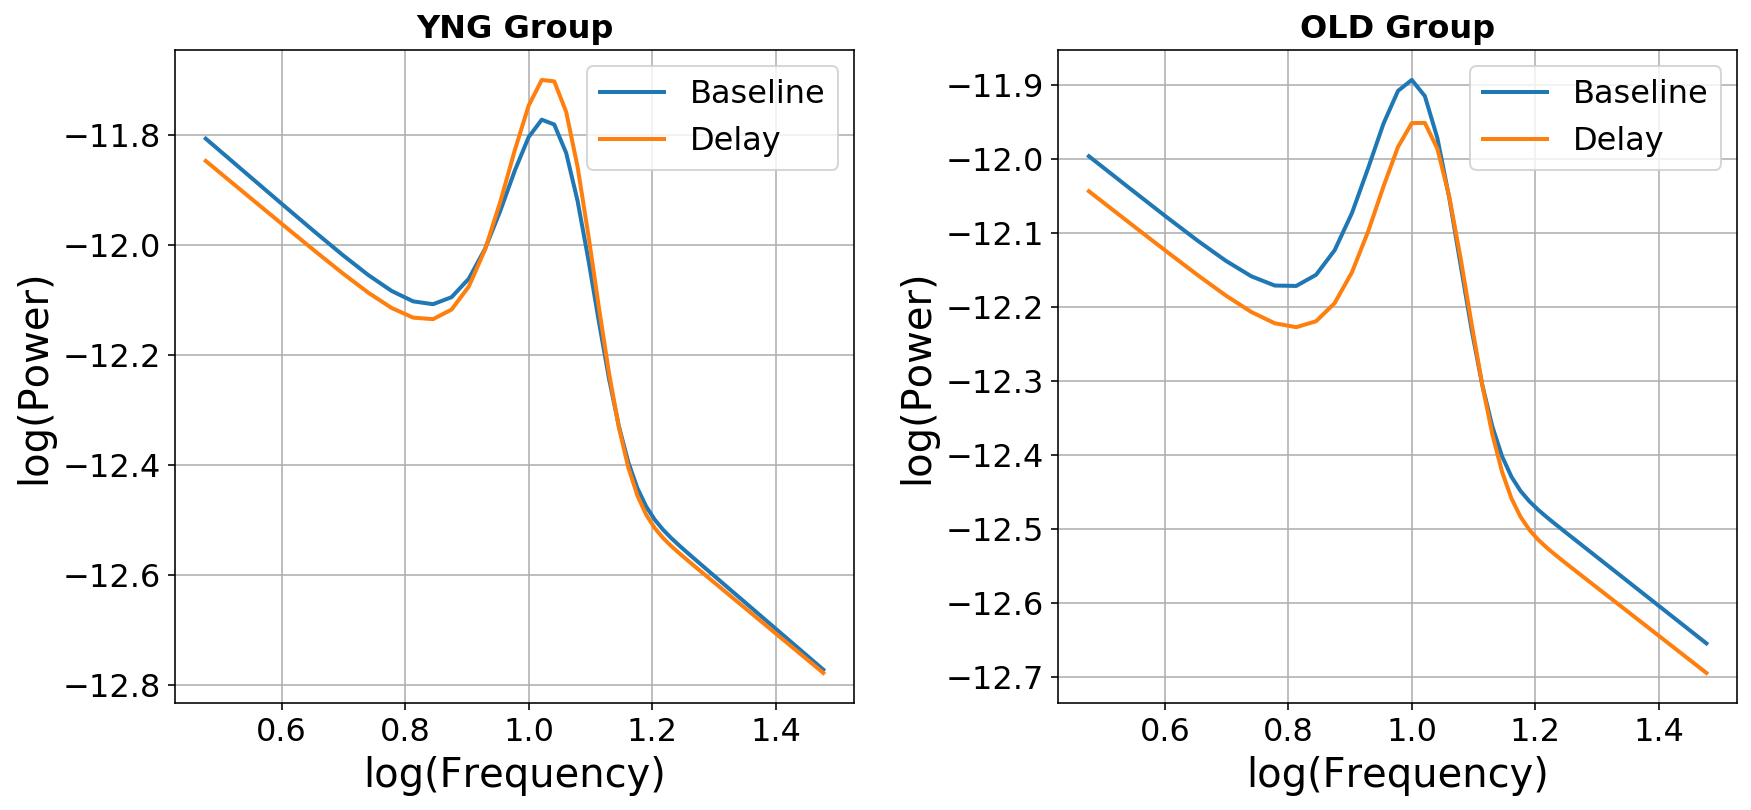

In [40]:
_, ax = plt.subplots(1, 2, figsize=(14, 6))
titles = ['YNG Group', 'OLD Group']
for ii, inds in enumerate([YNG_INDS, OLD_INDS]):

    time_offs = all_offsets[:, inds, :].mean(0).mean(0)
    time_exps = all_exps[:, inds, :].mean(0).mean(0)
    time_al_cf = all_alphas_cf[:, inds, :].mean(0).mean(0)
    time_al_pw = all_alphas_pw[:, inds, :].mean(0).mean(0)
    time_al_bw = all_alphas_bw[:, inds, :].mean(0).mean(0)

    fs, base_spectrum = gen_power_spectrum([3, 30],
                                           [time_offs[0], time_exps[0]],
                                           [time_al_cf[0], time_al_pw[0],
                                            time_al_bw[0]/2], nlv=0)
    fs, task_spectrum = gen_power_spectrum([3, 30],
                                           [time_offs[2], time_exps[2]],
                                           [time_al_cf[2], time_al_pw[2],
                                            time_al_bw[2]/2], nlv=0)

    plot_spectra(fs, [base_spectrum, task_spectrum],
                 True, True, ['Baseline', 'Delay'], ax=ax[ii])
    ax[ii].set_title(titles[ii], {'fontsize' : 16, 'fontweight' : 'bold'})
    
    print(titles[ii])
    for label, dat in zip(['Off', 'Exp', 'CF ', 'PW ', 'BW '],
                          [time_offs, time_exps,  time_al_cf, time_al_pw, time_al_bw]):
        print('\t', label, ' : {:+1.3f}'.format(dat[2] - dat[0]))
    
plt.subplots_adjust(wspace=0.3)
if SAVE_FIG:
    plt.savefig('../figures/EEG-TaskModels.png', dpi=500)

## Correlations Between Features

Check the correlation structure within and between FOOOF and canonical measures.

In [41]:
# Settings
group = 'ALL'
cur_dat = data_dict
#cur_dat = diff_data_dict

In [42]:
# Calculate and collect correlations between features
corrs = np.zeros(shape=[len(datas), len(datas)])
print('Correlations between features \t\t r-val \t\t p-val')
for i1, label1 in enumerate(labels):
    for i2, label2 in enumerate(labels):
        corr = nan_corr(cur_dat[group][label1].flatten(),
                        cur_dat[group][label2].flatten())
        if i1 != i2:
            corrs[i1, i2] = corr[0]
        else:
            corrs[i1, i2] = 0
        if i1 < i2:
            print('  {:10s} &   {} : \t\t{:+1.3f} \t\t{:1.4f}'.format(label1, label2, *corr))

Correlations between features 		 r-val 		 p-val
  offset     &   exponent : 		+0.780 		0.0000
  offset     &   alpha_cf : 		+0.157 		0.0084
  offset     &   alpha_pw : 		+0.327 		0.0000
  offset     &   alpha_bw : 		+0.406 		0.0000
  offset     &   canalpha : 		+0.125 		0.0365
  offset     &   canal_icf : 		+0.132 		0.0276
  exponent   &   alpha_cf : 		+0.215 		0.0003
  exponent   &   alpha_pw : 		+0.085 		0.1580
  exponent   &   alpha_bw : 		+0.095 		0.1125
  exponent   &   canalpha : 		+0.120 		0.0444
  exponent   &   canal_icf : 		+0.121 		0.0438
  alpha_cf   &   alpha_pw : 		+0.054 		0.3731
  alpha_cf   &   alpha_bw : 		+0.295 		0.0000
  alpha_cf   &   canalpha : 		+0.053 		0.3770
  alpha_cf   &   canal_icf : 		+0.060 		0.3189
  alpha_pw   &   alpha_bw : 		+0.428 		0.0000
  alpha_pw   &   canalpha : 		+0.342 		0.0000
  alpha_pw   &   canal_icf : 		+0.323 		0.0000
  alpha_bw   &   canalpha : 		-0.115 		0.0555
  alpha_bw   &   canal_icf : 		-0.122 		0.0421
  canalpha   &   canal_icf 

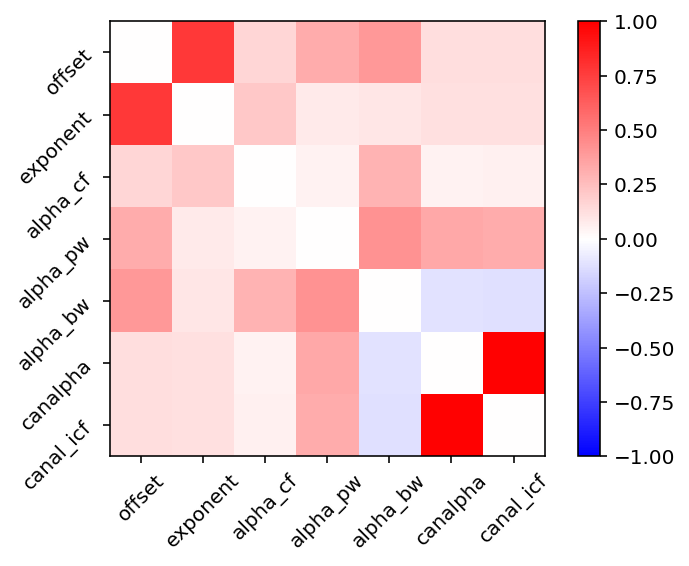

In [43]:
# Plot the correlation matrix between features
plt.imshow(corrs, cmap='bwr', vmin=-1, vmax=1)
plt.gca().set_xticklabels([''] + labels, rotation=45);
plt.gca().set_yticklabels([''] + labels, rotation=45);
plt.colorbar();

if SAVE_FIG:
    plt.savefig('../figures/EEG-ParamCorrs.png', dpi=500)

## Explore Relation Between Canonical Alpha and FOOOF Alpha & Exponent

In this section, we will explore how the canonical alpha measure relates to FOOOF measures.

The idea of the FOOOF model is that the measured power at a particular frequency, say 10 Hz or alpha, reflects a combination of aperiodic power and any band-specific oscillations. If so, the total power at a given frequency, as is traditionally computed, should be predictable by a combination of FOOOF features.

To check this, we will further explore the relationship between canonically measured alpha power, and FOOOF features for the aperiodic component (offset and exponent) and the FOOOF measure of alpha peak-specific power. 

In [44]:
# Generate the power @ alpha frequency given the aperiodic component, from the FOOOF fits
ap_alpha = []
for cf, off, exp in zip(all_alphas_cf.flatten(), all_offsets.flatten(), all_exps.flatten()):
    ap_alpha.append(gen_aperiodic(np.array([10]), [off, exp])[0])
ap_alpha = np.array(ap_alpha)

# Calculate the total power at 10 Hz (or about) from the combination of aperiodic & alpha peak
foo_total = ap_alpha + all_alphas_pw.flatten()

In [45]:
# Calculate correlation between canonical and FOOOF alpha
print_stat('C-Alpha vs F-Alpha     ', *nan_corr(np.array(all_alphas_pw.flatten()),
                                           np.array(canalpha.flatten())))
print_stat('C-ICF-Alpha vs F-Alpha ', *nan_corr(np.array(all_alphas_pw.flatten()),
                                               np.array(canal_icf.flatten())))

C-Alpha vs F-Alpha     : 	  0.3425 	 0.0000
C-ICF-Alpha vs F-Alpha : 	  0.3226 	 0.0000


In [46]:
# Calculate correlation between canonical alpha and aperiodic component @ 10 Hz
print_stat('C-Alpha vs 10Hz-AP', *nan_corr(np.array(ap_alpha),
                                           np.array(canalpha.flatten())))

C-Alpha vs 10Hz-AP: 	  0.0617 	 0.3045


In [47]:
# Calculate correlation between the canonical alpha and the FOOOF model total @ 10 Hz
print_stat('C-Alpha vs Total-FOOOF', *nan_corr(np.array(foo_total.flatten()),
                                               np.array(canalpha.flatten())))
print_stat('C-ICF-Alpha vs Total-FOOOF', *nan_corr(np.array(foo_total.flatten()),
                                                   np.array(canal_icf.flatten())))

C-Alpha vs Total-FOOOF: 	  0.2628 	 0.0000
C-ICF-Alpha vs Total-FOOOF: 	  0.2545 	 0.0000


To put it all together, let's see to what extent we can predict the canonically measured FOOOF

In [48]:
# Predict standard canonical alpha
data = pd.DataFrame()

group = 'ALL'
data['exp'] = diff_data_dict[group]['exponent']
data['off'] = diff_data_dict[group]['offset']
data['fal'] = diff_data_dict[group]['alpha_pw']
data['canal'] = diff_data_dict[group]['canalpha']

mod = run_model("canal ~ exp + off + fal", data, True)

                            OLS Regression Results                            
Dep. Variable:                  canal   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     143.3
Date:                Mon, 04 May 2020   Prob (F-statistic):           5.80e-34
Time:                        22:12:12   Log-Likelihood:                 1262.0
No. Observations:                  93   AIC:                            -2516.
Df Residuals:                      89   BIC:                            -2506.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.081e-07   4.68e-08     -2.308      0.0

In [49]:
# Check the predictions from individual components
m1 = run_model("canal ~ exp", data, False)
m2 = run_model("canal ~ off", data, False)
m3 = run_model("canal ~ fal", data, False)

print('Canal - EXP: \t{:1.4f}'.format(m1.rsquared_adj))
print('Canal - OFF: \t{:1.4f}'.format(m2.rsquared_adj))
print('Canal - FAL: \t{:1.4f}'.format(m3.rsquared_adj))

Canal - EXP: 	0.1709
Canal - OFF: 	0.0290
Canal - FAL: 	0.8006


In [50]:
# Predict individualized frequency canonical alpha
data = pd.DataFrame()

group = 'ALL'
data['exp'] = diff_data_dict[group]['exponent']
data['off'] = diff_data_dict[group]['offset']
data['fal'] = diff_data_dict[group]['alpha_pw']
data['canal'] = diff_data_dict[group]['canal_icf']

mod = run_model("canal ~ exp + off + fal", data, True)

                            OLS Regression Results                            
Dep. Variable:                  canal   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     135.3
Date:                Mon, 04 May 2020   Prob (F-statistic):           4.77e-33
Time:                        22:12:13   Log-Likelihood:                 1262.6
No. Observations:                  93   AIC:                            -2517.
Df Residuals:                      89   BIC:                            -2507.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.883e-08   4.66e-08     -1.908      0.0

In [51]:
# Check the predictions from individual components
m1 = run_model("canal ~ exp", data, False)
m2 = run_model("canal ~ off", data, False)
m3 = run_model("canal ~ fal", data, False)

print('Canal - EXP: \t{:1.4f}'.format(m1.rsquared_adj))
print('Canal - OFF: \t{:1.4f}'.format(m2.rsquared_adj))
print('Canal - FAL: \t{:1.4f}'.format(m3.rsquared_adj))

Canal - EXP: 	0.1461
Canal - OFF: 	0.0140
Canal - FAL: 	0.7839
